# vdl Depth and Class Constrained Diffusion
- **Name:** Nils Fahrni
- **Date:** 07.01.2025

## Dataset Preparation

- 894 classes -> 18 classes

In [1]:
from data.nyuv2 import NYUDepthV2
from torchvision import transforms
from torch.utils.data import DataLoader

mean = [0.5105, 0.4662, 0.4438]
std = [0.2273, 0.2275, 0.2409]

image_t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

crop_t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
])

dataset = NYUDepthV2(root='data', 
                     download=True, 
                     preload=False, 
                     image_transform=image_t, 
                     seg_transform=crop_t, 
                     depth_transform=crop_t, 
                     filtered_classes=[5, 11, 21, 26, 2, 3, 7, 64, 144, 19, 119, 157, 28, 55, 15, 59, 4, 83])

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

Dataset already exists, skipping download.


In [2]:
from data import split_dataset

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
import torch.nn as nn
import wandb
import matplotlib.pyplot as plt

class Analyzer:
    def __init__(self, model: nn.Module, device: str, project_name: str="vdl", entity_name: str="okaynils"):
        self.model = model
        self.device = device
        self.project_name = project_name
        self.entity_name = entity_name
        self.history = None
        pass
    
    def plot(self, wandb_id: str):
        if self.history is None:
            self._fetch_data(wandb_id)
        
        if self.history is not None:
            # Extract train_loss and val_loss from the list of dictionaries
            train_loss = [entry['train_loss'] for entry in self.history if entry['train_loss'] is not None]
            val_loss = [entry['val_loss'] for entry in self.history if entry['val_loss'] is not None]

            if train_loss and val_loss:
                plt.figure(figsize=(10, 6))
                plt.plot(train_loss, label='Train Loss')
                plt.plot(val_loss, label='Validation Loss')
                plt.title('Training and Validation Loss Over Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True)
                plt.show()
            else:
                raise ValueError("No valid train_loss or val_loss found in the history.")
        
    def _fetch_data(self, wandb_id: str):
        api = wandb.Api()
        try:
            run = api.run(f"{self.entity_name}/{self.project_name}/{wandb_id}")
            self.history = run.history()
            print(self.history)
        except wandb.errors.CommError as e:
            raise ValueError(f"Error fetching run: {e}")

Unable to load pandas, call history with pandas=False
[{'val_loss': 0.40003236025980077, '_step': 0, 'epoch': 1, 'train_loss': 0.8548378405843194, 'test_loss': None, '_runtime': 191.929678838, 'FID': None, 'PSNR': None, '_timestamp': 1735396779.3245819, 'Validation Samples': None, 'learning_rate': 1e-05}, {'val_loss': None, '_step': 1, 'epoch': None, 'train_loss': None, 'test_loss': None, '_runtime': 242.315813744, 'FID': 2.4364563021732218e+25, 'PSNR': 4.445549964904785, '_timestamp': 1735396829.710718, 'Validation Samples': None, 'learning_rate': None}, {'val_loss': None, '_step': 2, 'epoch': None, 'train_loss': None, 'test_loss': None, '_runtime': 243.398357466, 'FID': None, 'PSNR': None, '_timestamp': 1735396830.793349, 'Validation Samples': {'_type': 'image-file', 'format': 'png', 'path': 'media/images/Validation Samples_2_ad2b452b77457d4fa996.png', 'sha256': 'ad2b452b77457d4fa9966186cba8f48af11d84f05369ec629d1ef80e91c918cc', 'size': 270281, 'height': 900, 'width': 1200}, 'learnin

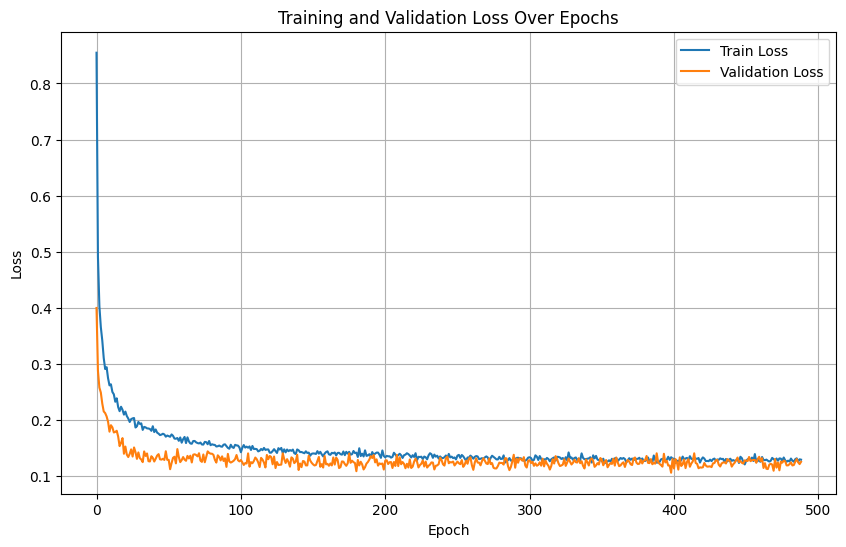

In [46]:

analyzer = Analyzer(model, device).plot('o6mtkrvr')

In [31]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet_Attn(num_classes=18, dropout_prob=0.2, device=device).to(device)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

ema_model.load_state_dict(torch.load('models/unet_attn_dropout_0.2_o6mtkrvr_ema.pth', map_location=device))

C:\Users\fahrn\AppData\Local\Temp\ipykernel_35656\875099622.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ema_model.load_state_dict(torch.load('models/unet_attn_dropou

Unable to load pandas, call history with pandas=False
[{'val_loss': 0.40003236025980077, '_step': 0, 'epoch': 1, 'train_loss': 0.8548378405843194, 'test_loss': None, '_runtime': 191.929678838, 'FID': None, 'PSNR': None, '_timestamp': 1735396779.3245819, 'Validation Samples': None, 'learning_rate': 1e-05}, {'val_loss': None, '_step': 1, 'epoch': None, 'train_loss': None, 'test_loss': None, '_runtime': 242.315813744, 'FID': 2.4364563021732218e+25, 'PSNR': 4.445549964904785, '_timestamp': 1735396829.710718, 'Validation Samples': None, 'learning_rate': None}, {'val_loss': None, '_step': 2, 'epoch': None, 'train_loss': None, 'test_loss': None, '_runtime': 243.398357466, 'FID': None, 'PSNR': None, '_timestamp': 1735396830.793349, 'Validation Samples': {'_type': 'image-file', 'format': 'png', 'path': 'media/images/Validation Samples_2_ad2b452b77457d4fa996.png', 'sha256': 'ad2b452b77457d4fa9966186cba8f48af11d84f05369ec629d1ef80e91c918cc', 'size': 270281, 'height': 900, 'width': 1200}, 'learnin

TypeError: list indices must be integers or slices, not str

## Modules

In [5]:
from core import UNet_Baseline
from core import UNet_Attn

# Instantiate the model
baseline = UNet_Baseline(num_classes=18, device=device).to(device)
attn = UNet_Attn(num_classes=18, device=device).to(device)

# Dummy inputs
x = torch.randn(1, 3, 64, 64).to(device)
t = torch.randint(0, 1000, (x.shape[0],)).to(device)
class_vector = torch.ones((x.shape[0], 18)).to(device)
depth_vector = torch.zeros((x.shape[0], 18)).to(device)

for net in [baseline, attn]:
    output = net(x, t, class_vector, depth_vector)
    print(f'--- Model: {net.__class__.__name__} ---')
    print(f"Total parameters: {sum(p.numel() for p in net.parameters())}")
    print(f'Input shape: {x.shape}')
    print(f"Output shape: {output.shape}")
    print()

--- Model: UNet_Baseline ---
Total parameters: 1771907
Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 64, 64])

--- Model: UNet_Attn ---
Total parameters: 23539331
Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 64, 64])



## Diffusion

In [6]:
from diffusion import Diffusion

## Trainer

In [7]:
from trainer import Trainer

In [8]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset[:24], train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Training samples: 16
Validation samples: 4
Testing samples: 4


In [9]:
from core import UNet_Attn
# import copy here
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet_Attn(num_classes=18, dropout_prob=0.2, device=device).to(device)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

ema_model.load_state_dict(torch.load('models/unet_attn_dropout_0.2_o6mtkrvr_ema.pth', map_location=device))

C:\Users\fahrn\AppData\Local\Temp\ipykernel_35656\1153786167.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ema_model.load_state_dict(torch.load('models/unet_attn_drop

<All keys matched successfully>

In [10]:
# a 894-dimensional class vector with some 1s and 0s
class_vector = torch.tensor(dataset[0][3]).unsqueeze(0)
depth_vector = torch.tensor(dataset[0][4]).unsqueeze(0)

dataset.resolved_names 

class_vector = torch.tensor([0]*18)
print(dataloader.dataset.resolved_names)

class_vector[0] = 1
class_vector[15] = 1

depth_vector = torch.tensor([0]*18)
depth_vector[0] = 1.3
depth_vector[15] = 3.0

['chair' 'floor' 'wall' 'box' 'bottle' 'cabinet' 'counter' 'picture'
 'lamp' 'table' 'pillow' 'bed' 'door' 'bag' 'paper' 'window' 'ceiling'
 'sofa']


In [11]:
class_vector.shape, depth_vector.shape

(torch.Size([18]), torch.Size([18]))

In [12]:
diffusion = Diffusion(beta_start=0.0001, beta_end=0.002, device=device)

sampled_images = diffusion.sample(ema_model, 1, torch.tensor(train_dataset[1][3]).unsqueeze(0).to(device), torch.tensor(train_dataset[1][4]).unsqueeze(0).to(device))

02:26:57 - INFO: Sampling 1 new images from UNet_Attn...
999it [00:19, 50.61it/s]


In [13]:
sampled_images.shape

torch.Size([1, 3, 64, 64])

In [14]:
#plt.imshow(train_dataset[1][0].permute(1,2,0))
train_dataset[1][3], train_dataset[1][4]

(array([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
        0.], dtype=float32),
 array([3.899875 , 5.4697165, 3.951857 , 3.3675194, 4.5320315, 3.1576278,
        5.00796  , 9.751564 , 0.       , 4.110116 , 0.       , 0.       ,
        0.       , 0.       , 3.459803 , 4.5213976, 3.1027713, 0.       ],
       dtype=float32))

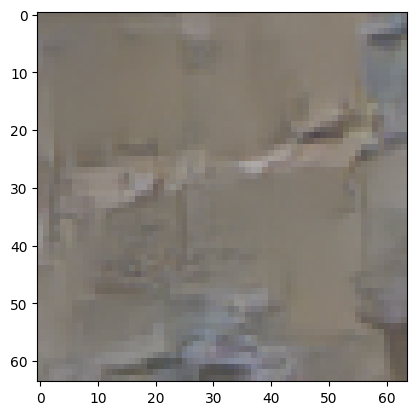

In [20]:
from data import unnormalize

plt.imshow(unnormalize(sampled_images[0].cpu(),mean,std).permute(1, 2, 0))
plt.show()

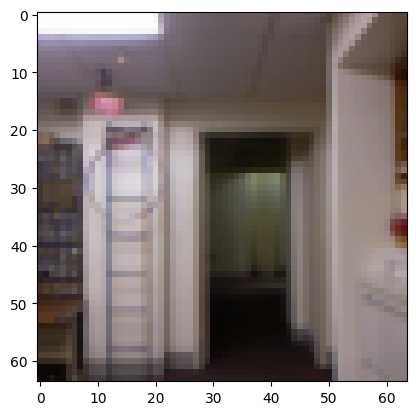

In [16]:
plt.imshow(unnormalize(train_dataset[1][0], mean, std).permute(1, 2, 0))

In [17]:
plot_image(sampled_images[0], mean, std, value_range="[0, 1]")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.